In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install evaluate

In [ ]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, TrainingArguments, Trainer, default_data_collator
from datasets import load_dataset, DatasetDict, Dataset
import torch
import json
import numpy as np
import random
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.optim import AdamW
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
from transformers import pipeline
import evaluate
from evaluate import load
from sklearn.metrics import f1_score
import json
from collections import defaultdict
from difflib import SequenceMatcher

In [ ]:

import os

cache_dir = "/content/drive/MyDrive/huggingface_cache"
os.makedirs(cache_dir, exist_ok=True)

from transformers import AutoTokenizer, AutoModelForQuestionAnswering

model_name = "pedramyazdipoor/persian_xlm_roberta_large"

tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=cache_dir)
model = AutoModelForQuestionAnswering.from_pretrained(model_name, cache_dir=cache_dir)

In [ ]:
### load model

from transformers import AutoTokenizer, AutoModelForQuestionAnswering

cache_dir = "/content/drive/MyDrive/huggingface_cache"
model_name = "pedramyazdipoor/persian_xlm_roberta_large"

tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=cache_dir)
model = AutoModelForQuestionAnswering.from_pretrained(model_name, cache_dir=cache_dir)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
print(model)

# XLM-RoBERTa for Question Answering

The core model is based on `XLMRobertaForQuestionAnswering` from HuggingFace's 🤗 Transformers library. It extends the `XLMRobertaModel` backbone with a QA-specific output layer.

### Components

- **XLM-RoBERTa Backbone (`roberta`)**
  - **Embeddings**
    - `word_embeddings`: Maps input tokens (vocabulary size: 250002) to 1024-dimensional vectors.
    - `position_embeddings`: Learns positional information up to 514 tokens.
    - `token_type_embeddings`: A single embedding for token type (not used in RoBERTa but retained for compatibility).
    - `LayerNorm` and `Dropout`: Applied to stabilize and regularize embeddings.
  - **Encoder**
    - 24 Transformer layers (denoted as `XLMRobertaLayer`) with:
      - **Self-attention (Multi-head)**: Uses `XLMRobertaSdpaSelfAttention` to learn contextual token representations.
      - **Feed-forward layers**: Each layer has an intermediate dimension of 4096 with GELU activation, followed by output projections back to 1024.
      - **LayerNorm** and `Dropout` applied at each sub-layer.

- **Question Answering Head (`qa_outputs`)**
  - A linear layer mapping the 1024-dimensional encoder outputs to two logits per token, representing:
    - Start position of the answer span.
    - End position of the answer span.

# **First Evaluation (on pQuAD data)**

In [ ]:

def load_pqa(path):
    with open(path, encoding='utf-8') as f:
        data = json.load(f)

    samples = []
    for article in data["data"]:
        for paragraph in article["paragraphs"]:
            context = paragraph["context"]
            for qa in paragraph["qas"]:
                question = qa["question"]
                id_ = qa["id"]
                answers = qa["answers"]
                answer_texts = [ans["text"] for ans in answers]
                answer_starts = [ans["answer_start"] for ans in answers]
                samples.append({
                    "id": id_,
                    "context": context,
                    "question": question,
                    "answers": {
                        "text": answer_texts,
                        "answer_start": answer_starts
                    }
                })
    return samples

train_samples = load_pqa("/content/drive/MyDrive/PersianQA/pQuad/Train.json")
test_samples  = load_pqa("/content/drive/MyDrive/PersianQA/pQuad/Test.json")

# Split training set for validation
#train_data, val_data = train_test_split(train_samples, test_size=0.1, random_state=42)

'''
dataset = DatasetDict({
    "train": Dataset.from_list(train_data),
    "validation": Dataset.from_list(val_data),
    "test": Dataset.from_list(test_samples)
})
'''
'''
# ✅ Filter answerable samples only
def is_answerable(sample):
    return len(sample["answers"]["answer_start"]) > 0 and sample["answers"]["text"][0].strip() != ""

answerable_train_samples = [s for s in train_samples if is_answerable(s)]

'''
dataset = DatasetDict({
    "train": Dataset.from_list(train_samples),
    "test": Dataset.from_list(test_samples)
})

# 🧪 Preprocessing function for QA
def preprocess(example):
    questions = [q.strip() for q in example["question"]]
    contexts = example["context"]
    answers_list = example["answers"]

    tokenized = tokenizer(
        questions,
        contexts,
        max_length=384,
        stride=128,
        truncation="only_second",
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length"
    )

    sample_mapping = tokenized.pop("overflow_to_sample_mapping")
    offset_mapping = tokenized.pop("offset_mapping")

    start_positions = []
    end_positions = []

    for i, offsets in enumerate(offset_mapping):
        input_ids = tokenized["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        sequence_ids = tokenized.sequence_ids(i)
        sample_idx = sample_mapping[i]
        answers = answers_list[sample_idx]

        if len(answers["answer_start"]) == 0:
            start_positions.append(cls_index)
            end_positions.append(cls_index)
        else:
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])

            token_start_index = 0
            while sequence_ids[token_start_index] != 1:
                token_start_index += 1

            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != 1:
                token_end_index -= 1

            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                start_positions.append(cls_index)
                end_positions.append(cls_index)
            else:
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                start_positions.append(token_start_index - 1)

                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                end_positions.append(token_end_index + 1)

    tokenized["start_positions"] = start_positions
    tokenized["end_positions"] = end_positions

    return tokenized


# 🔄 Apply preprocessing
tokenized_datasets = dataset.map(preprocess, batched=True, remove_columns=dataset["train"].column_names)




In [ ]:


def freeze_all_bert_layers(model):
    for param in model.roberta.parameters():
        param.requires_grad = False

    for param in model.qa_outputs.parameters():
        param.requires_grad = True

def unfreeze_last_n_layers(model, n):
    for layer in model.roberta.encoder.layer[-n:]:
        for param in layer.parameters():
            param.requires_grad = True



train_dataloader = DataLoader(tokenized_datasets["train"], batch_size=16, shuffle=True, collate_fn=default_data_collator)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

freeze_all_bert_layers(model)
unfreeze_last_n_layers(model,2)

optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                  lr=2e-5)
model.to(device)


In [ ]:

def focal_loss(logits, targets, gamma=2.0, reduction='mean'):
    log_probs = F.log_softmax(logits, dim=-1)
    probs = torch.exp(log_probs)
    target_log_probs = log_probs.gather(dim=-1, index=targets.unsqueeze(-1)).squeeze(-1)
    target_probs = probs.gather(dim=-1, index=targets.unsqueeze(-1)).squeeze(-1)

    loss = -((1 - target_probs) ** gamma) * target_log_probs
    return loss.mean() if reduction == 'mean' else loss

def qa_focal_loss(start_logits, end_logits, start_positions, end_positions, gamma=2.0):
    start_loss = focal_loss(start_logits, start_positions, gamma=gamma)
    end_loss = focal_loss(end_logits, end_positions, gamma=gamma)
    return (start_loss + end_loss) / 2

##########

def make_binary_targets(positions, seq_len):
    # positions: (batch,)
    # returns: (batch, seq_len)
    batch_size = positions.size(0)
    binary = torch.zeros((batch_size, seq_len), device=positions.device)
    binary[torch.arange(batch_size), positions] = 1.0
    return binary

def loss_fn(out1,out2,target1,target2):
  l1 = nn.BCEWithLogitsLoss()(out1, target1.float())
  l2 = nn.BCEWithLogitsLoss()(out2, target2.float())
  return l1 + l2

num_epochs = 1

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    model.train()
    totall_loss = 0

    progress_bar = tqdm(train_dataloader)
    for batch in progress_bar:
        batch = {k: v.to(device) for k, v in batch.items()}
        '''
        outputs = model(**batch)
        loss = outputs.loss


        outputs = model(**batch)
        loss = qa_focal_loss(
            outputs.start_logits,
            outputs.end_logits,
            batch["start_positions"],
            batch["end_positions"],
            gamma=1.6
        )
        '''

        outputs = model(**batch)
        start_logits = outputs.start_logits  # shape: (batch, seq_len)
        end_logits = outputs.end_logits

        seq_len = start_logits.size(1)

        # Convert class indices to binary vectors
        target_start = make_binary_targets(batch["start_positions"], seq_len)
        target_end = make_binary_targets(batch["end_positions"], seq_len)

        loss = loss_fn(start_logits, end_logits, target_start, target_end)


        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        totall_loss += loss.item()
        progress_bar.set_description(f"Loss: {loss.item():.4f}")

    avg_loss = totall_loss / len(train_dataloader)
    print(f"Epoch {epoch+1} average loss: {avg_loss:.4f}")

In [ ]:

device = 0 if torch.cuda.is_available() else -1
print("Device set to use:", "cuda:0" if device == 0 else "CPU")

with open('/content/drive/MyDrive/pQuad/Test.json', encoding='utf-8') as f:
    squad_data = json.load(f)

def squad_to_dataset(squad_dict):
    data = []
    for article in squad_dict['data']:
        for paragraph in article['paragraphs']:
            context = paragraph['context']
            for qa in paragraph['qas']:
                question = qa['question']
                id_ = qa['id']
                answers = qa['answers']
                answer_texts = [a['text'] for a in answers]
                answer_starts = [a['answer_start'] for a in answers]
                data.append({
                    'id': id_,
                    'context': context,
                    'question': question,
                    'answers': {
                        'text': answer_texts,
                        'answer_start': answer_starts
                    }
                })
    return Dataset.from_list(data)

test_dataset = squad_to_dataset(squad_data)

# Step 5: Run predictions using pipeline
qa_pipeline = pipeline("question-answering", model=model, tokenizer=tokenizer, device=device)

predictions = []
for item in test_dataset:
    result = qa_pipeline({
        'question': item['question'],
        'context': item['context']
    })
    predicted_text = result['answer'].strip()

    predictions.append({
        'id': item['id'],
        'prediction_text': predicted_text,
        'no_answer_probability': 1.0 if predicted_text == "" else 0.0  # Handle unanswerables
    })

# Step 6: Format references
references = [{
    'id': item['id'],
    'answers': item['answers']  # Includes empty list if unanswerable
} for item in test_dataset]

# Step 7: Evaluate using squad_v2
metric = evaluate.load("squad_v2")

results = metric.compute(predictions=predictions, references=references)

# Step 8: Print scores
print("F1 Score:", results['f1'])
print("Exact Match:", results['exact'])

Device set to use: CPU


Device set to use cpu


F1 Score: 5.009442215605195
Exact Match: 0.11247188202949263


In [ ]:
# a random sample test
sample = random.choice(test_dataset)

context = sample['context']
question = sample['question']
true_answers = sample['answers']['text']
true_answer = true_answers[0] if true_answers else ""

result = qa_pipeline({'question': question, 'context': context})
predicted_answer = result['answer']

exact_match = int(predicted_answer.strip() == true_answer.strip())

def compute_f1(pred, truth):
    pred_tokens = pred.strip().split()
    truth_tokens = truth.strip().split()
    common = set(pred_tokens) & set(truth_tokens)
    if not common:
        return 0.0
    precision = len(common) / len(pred_tokens)
    recall = len(common) / len(truth_tokens)
    return 2 * (precision * recall) / (precision + recall)

f1 = compute_f1(predicted_answer, true_answer)

print("\n--- RANDOM SAMPLE ---")
print(f"📌 Question: {question}")
print(f"📚 Context: {context[:300]}...")  # Print first 300 chars
print(f"✅ True Answer: {true_answer}")
print(f"🤖 Model Prediction: {predicted_answer}")
print(f"📈 Exact Match (EM): {exact_match}")
print(f"📉 F1 Score: {f1:.2f}")


--- RANDOM SAMPLE ---
📌 Question: تحصیلات جیمی کارتر در چه زمینه‌ای است؟
📚 Context: جیمز ارل کارتر جونیور (به انگلیسی: James Earl Carter Jr.) (زادهٔ ۱ اکتبر ۱۹۲۴) معروف به جیمی کارتر یک سیاستمدار، تاجر و خیّر آمریکایی است که طی سال‌های ۱۹۷۷ تا ۱۹۸۱ به عنوان سی و نهمین رئیس‌جمهور ایالات متحده آمریکا از حزب دموکرات فعالیت می‌کرد. وی قبل از ریاست‌جمهوری از سال ۱۹۶۳ تا ۱۹۶۷ به عنوان...
✅ True Answer: 
🤖 Model Prediction: عنوان یک شهروند درگیر پروژه‌های سیاسی و
📈 Exact Match (EM): 0
📉 F1 Score: 0.00


## First Evaluation and Next Steps

The model used in this project was originally fine-tuned on the PQuAD dataset and made available via the Hugging Face Hub. However, upon loading the model, we encountered an issue where the question answering head (qa_outputs) was not properly restored. Although the transformer backbone of the model was correctly loaded, the QA head—the component responsible for span prediction—was randomly initialized. As a result, evaluation on the PQuAD test set led to very low F1 and EM scores, which are not representative of the model's true capability.

This incomplete restoration means we cannot rely on the current evaluation metrics for PQuAD, as the model is effectively missing its trained QA prediction layer. While one possible solution would be to re-train the QA head on PQuAD to recover its performance, this step is not strictly required. The underlying transformer layers, which carry most of the language understanding and contextual encoding, were successfully loaded and already benefit from PQuAD fine-tuning.

Given this, we proceed directly to fine-tuning the model on a new dataset—PersianQA. During this process, we freeze the transformer layers and train only the QA head on PersianQA samples. This allows us to benefit from the strong Persian language representations learned from PQuAD, while adapting the model efficiently to a new task without the need to revisit the original dataset.


# **Fine Tune on PersianQA**

## Methods and Results

## Fine-Tuning Strategies for Transformer QA Model


### Gradual Layer Unfreezing During Training
- **What**: Start training with most layers frozen, and progressively unfreeze more layers as training proceeds (e.g., N layer every 1 epoch).
- **Pros**:
  - Efficient and dynamic.
  - Stabilizes training and reduces overfitting risk.
- **Why We Chose It**:
  - It adapts learning capacity over time.
  - Good real-world performance with less hyperparameter tuning.

- **Results:**
  - **F1 Score: 69.7**  
  - **Exact Match (EM): 57.53**  
  - **No-Answer F1: 90**





### **Stepwise Fine-Tuning Strategy**

I used a stepwise fine-tuning approach to improve question answering performance.  
The process began with training only on answerable questions, and then I explored two different strategies to continue training on the full dataset.

I trained the model using only **answerable samples** from the dataset.  
This allowed the model to focus on span prediction without being confused by unanswerable cases.

**Results:**
  - **Has-Ans F1 Score: 61.7**  
  - **Has-Ans Exact Match (EM):43.6**  
  - **No-Answer F1: 39.4**
---


 - **Approach 1: Continue Fine-Tuning on Full Dataset**

  I took the previously trained model (on answerable data) and continued fine-tuning it on the complete dataset.

  However, this method **did not improve results** compared to training on the full dataset from the beginning.

  **Results:**
  - **F1 Score: 66.2**  
  - **Exact Match (EM): 53.3**  
  - **No-Answer F1: 82.1**

---

 - **Approach 2: Add Learnable Threshold to Handle No-Answer**

  In this approach, I introduced a **learnable threshold parameter** during training.  
  The goal was to reduce over-prediction of "no answer" by encouraging the model to predict spans unless the [CLS] score was clearly higher.

  Although promising in theory, this approach had two major issues:
  - **Training became very slow** (~1.5 hours per epoch on BERT),
  - **Convergence was difficult** — even after an epoch, there was no clear improvement in accuracy.






### **Method 3: LoRA + QA Head Tuning**

#### **Approach 1: Trust Pretrained Weights + LoRA + QA Head**

- Started with a pretrained RoBERTa (by Mr. Yazdipoor).
- Added LoRA modules and tuned with QA head.
- Tested combinations of `(r, alpha)`: [16,16], [16,32], [32,32]

Then:
- Applied **Focal Loss** (γ = 1.65) based on previous BERT results.
- This improved handling of **no-answer cases**, but did not outperform the earlier LoRA model.

#### **Approach 2: Tune Base First → Add LoRA + QA Head**

- Did not assume pretrained model was optimal.
- First fine-tuned base model, then added LoRA + QA head.
- Tested same LoRA `(r, alpha)` combinations as above.
- Result: No improvement over Approach 1.

---


## **Secondary Evaluation and Experiments**

Despite applying all methods and approaches, the F1 score plateaued around **68%**. This raised doubts about:

### Data Processing

- Re-verified cleaning and preprocessing pipeline → No issues found.

### QA Head Initialization

Hypothesis: Random initialization of QA head may be limiting.

Tested:
1. **Xavier Initialization**
2. **QA head from similar pretrained model** ((deepset/roberta-large-squad2))

For both:
- Applied **Method 1 (Gradual Unfreeze)** and **Method 3 (LoRA + QA Head)**.
- Combined with various loss functions: **CE**, **BCE**, **Focal**.
- Still, **F1 hovered around 68%**.

### Discovery: Effect of Truncation

Suspected input **truncation** (due to max length) was hurting attention. Transformer models do **not retain state** across input chunks.

- Increased `max_length` from **384 → 512**.

**Effect**: Performance **dramatically improved**.



## ✅ Final Results

### 🔹 Stepwise Training (Method 1)

- F1 Score: **84.8**
- Exact Match (EM): **70.6**
- No-Answer F1: **89.6**

### 🔹 Adding LoRA + QA Head on Top

- F1 Score: **85.3**
- Exact Match (EM): **71.6**
- No-Answer F1: **90.7**

## Summary Table

| Method                                  | F1 Score | EM Score | No-Answer F1 | Notes |
|----------------------------------------|----------|----------|---------------|-------|
| Gradual Unfreezing (Method 1)          | 69.7     | 57.53    | 90.0          | Baseline strong |
| Stepwise (Answerable only)             | 61.7     | 43.6     | 39.4          | Initial pretraining |
| + Full Dataset Fine-tuning             | 66.2     | 53.3     | 82.1          | Didn’t improve much |
| + Learnable Threshold (CLS)            | —        | —        | —             | Training unstable |
| LoRA + QA Head (Trust base)            | ~68      | —        | —             | Best approach before token length fix |
| LoRA + Focal Loss (γ=1.65)             | ~68      | —        | Improved      | Better No-Ans handling |
| LoRA (Full finetune first)             | ~68      | —        | —             | No gain |
| After fixing max_len=512               | 84.8     | 70.6     | 89.6          | Major improvement |
| + LoRA + QA Head on fixed model        | **85.3** | **71.6** | **90.7**      | Final best result |

---

### data preprocessing

In [ ]:
'''
# uncomment this carefully
from hazm import Normalizer
normalizer = Normalizer()
'''
def clean_text(text):
    import re

    #text = normalizer.normalize(text)

    # Normalize Persian/Arabic characters
    text = text.replace('ك', 'ک').replace('ي', 'ی').replace('ۀ', 'ه').replace('ة', 'ه')
    text = text.replace('أ', 'ا').replace('إ', 'ا').replace('ؤ', 'و').replace('ئ', 'ی').replace('آ', 'ا')
    # Remove ZWNJ and Tatweel
    text = text.replace('\u200c', '')  # ZWNJ
    text = text.replace('\u0640', '')  # Tatweel (kashida)
    text = text.replace('\u200d', '')  # ZWJ
    text = text.replace('\u200e', '')  # ZWJ
    text = text.replace('\u200f', '')  # ZWJ
    # Remove extra space around math and assignment symbols
    text = re.sub(r'\s*=\s*', '=', text)
    text = re.sub(r'\s*\+\s*', '+', text)
    text = re.sub(r'\s*-\s*', '-', text)
    text = re.sub(r'\s*\*\s*', '*', text)
    text = re.sub(r'\s*/\s*', '/', text)
    # Remove spaces around long dash
    text = re.sub(r'\s*–\s*', '–', text)
    # Normalize ellipsis variations (e.g. "و…", "و …" → "و...")
    text = re.sub(r'\s*…', '...', text)
    text = text.replace('...', '…')  # unify all to Persian ellipsis
    # Normalize spacing around hyphens
    text = re.sub(r'\s*-\s*', '-', text)
    # Collapse multiple spaces
    text = re.sub(r'\s+', ' ', text)
    # Remove space before Persian/English punctuation
    text = re.sub(r'\s+([.,،؛!?])', r'\1', text)
    # Add space after punctuation if missing
    text = re.sub(r'([.,،؛!?])([^\s])', r'\1 \2', text)
    # Lowercase English
    text = re.sub(r'[A-Z]', lambda m: m.group(0).lower(), text)

    return text.strip()


def load_pqa(path):
    import json

    with open(path, encoding='utf-8') as f:
        data = json.load(f)

    samples = []
    for article in data["data"]:
        for paragraph in article["paragraphs"]:
            original_context = paragraph["context"]
            context = clean_text(original_context)

            for qa in paragraph["qas"]:
                question = clean_text(qa["question"])
                id_ = qa["id"]
                is_impossible = qa.get("is_impossible", False)
                answers = qa["answers"]

                answer_texts = []
                answer_starts = []
                answer_ends = []

                for ans in answers:
                    answer_text_raw = ans["text"]
                    answer_text = clean_text(answer_text_raw)

                    start = context.find(answer_text)
                    if start != -1:
                        answer_texts.append(answer_text)
                        answer_starts.append(start)
                        answer_ends.append(start + len(answer_text))
                    else:
                        # Log or skip misaligned answers if needed
                        #print(f"⚠️ Could not find answer in context for id {id_}")
                        continue

                samples.append({
                    "id": str(id_),
                    "context": context,
                    "question": question,
                    "is_impossible": is_impossible,
                    "answers": {
                        "text": answer_texts,
                        "answer_start": answer_starts,
                        "answer_end": answer_ends
                    }
                })
    return samples


def preprocess_persianqa(example):
    tokenized = tokenizer(
        example["question"],
        example["context"],
        truncation="only_second",
        max_length=384,
        stride=64,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length"
    )

    sample_mapping = tokenized.pop("overflow_to_sample_mapping")
    offset_mapping = tokenized["offset_mapping"]

    tokenized["start_positions"] = []
    tokenized["end_positions"] = []
    tokenized["example_id"] = []

    for i, offsets in enumerate(offset_mapping):
        input_ids = tokenized["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        sequence_ids = tokenized.sequence_ids(i)
        sample_idx = sample_mapping[i]
        tokenized["example_id"].append(example["id"][sample_idx])

        is_impossible = example.get("is_impossible", [False])[sample_idx]
        answers = example["answers"][sample_idx]

        if is_impossible or len(answers["answer_start"]) == 0:
            tokenized["start_positions"].append(cls_index)
            tokenized["end_positions"].append(cls_index)
            continue

        start_char = answers["answer_start"][0]
        end_char = answers["answer_end"][0]

        # Find the token indices that map to the answer
        token_start_index = 0
        while sequence_ids[token_start_index] != 1:
            token_start_index += 1
        token_end_index = len(input_ids) - 1
        while sequence_ids[token_end_index] != 1:
            token_end_index -= 1

        if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
            tokenized["start_positions"].append(cls_index)
            tokenized["end_positions"].append(cls_index)
        else:
            # Find start token index
            while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                token_start_index += 1
            tokenized["start_positions"].append(token_start_index - 1)

            # Find end token index
            while token_end_index >= 0 and offsets[token_end_index][1] >= end_char:
                token_end_index -= 1
            tokenized["end_positions"].append(token_end_index + 1)

    return tokenized


def find_corrupted_samples_fast(tokenized_dataset, original_dataset, tokenizer):
    from collections import defaultdict

    original_lookup = {sample["id"]: sample for sample in original_dataset["train"]}

    corrupted = []

    for i, tokenized_sample in enumerate(tokenized_dataset["train"]):
        input_ids = tokenized_sample["input_ids"]
        start_pos = tokenized_sample["start_positions"]
        end_pos = tokenized_sample["end_positions"]
        example_id = tokenized_sample["example_id"]

        original_sample = original_lookup.get(example_id)
        if not original_sample:
            corrupted.append({
                "index": i,
                "id": example_id,
                "reason": "Original sample not found"
            })
            continue

        cls_index = input_ids.index(tokenizer.cls_token_id)
        '''
        answer_ids = input_ids[start_pos:end_pos+1]
        decoded_answer = clean_text(tokenizer.decode(answer_ids, skip_special_tokens=True).strip())
        '''
        if start_pos == end_pos == cls_index:
            decoded_answer = ''
        else:
            answer_ids = input_ids[start_pos:end_pos+1]
            decoded_answer = tokenizer.decode(answer_ids, skip_special_tokens=True).strip()
            decoded_answer = clean_text(decoded_answer)

        original_answers = original_sample["answers"]["text"]
        original_answer = clean_text(original_answers[0].strip()) if original_answers else ""
        is_unanswerable = (original_answer == "")

        if is_unanswerable:
            if not (start_pos == end_pos == cls_index):
                corrupted.append({
                    "index": i,
                    "id": example_id,
                    "type": "unanswerable",
                    "reason": "Unanswerable but not pointing to CLS token",
                    "start_pos": start_pos,
                    "end_pos": end_pos,
                })
        else:
            if original_answer not in decoded_answer:
                corrupted.append({
                    "index": i,
                    "id": example_id,
                    "type": "answerable",
                    "reason": "Decoded answer does not match original",
                    "original_answer": original_answer,
                    "decoded_answer": decoded_answer,
                })

    print(f"\n✅ Total corrupted samples: {len(corrupted)} / {len(tokenized_dataset['train'])}")
    return corrupted


In [ ]:
# data preprocessing

train_samples = load_pqa("/content/drive/MyDrive/PersianQA/pqa_train.json")
test_samples  = load_pqa("/content/drive/MyDrive/PersianQA/pqa_test.json")


'''
# ✅ Filter answerable samples only
def is_answerable(sample):
    return len(sample["answers"]["answer_start"]) > 0 and sample["answers"]["text"][0].strip() != ""

answerable_train_samples = [s for s in train_samples if is_answerable(s)]

'''
dataset = DatasetDict({
    "train": Dataset.from_list(train_samples),
    "test": Dataset.from_list(test_samples)
})

tokenized_datasets = dataset.map(
    preprocess_persianqa,
    batched=True,
    remove_columns=dataset["train"].column_names
)
corrupted_samples = find_corrupted_samples_fast(tokenized_datasets, dataset, tokenizer)

corrupted_ids = set([sample["id"] for sample in corrupted_samples])

# Add manually identified IDs with "⚠️ Could not find answer in context"
manual_corrupt_ids = {"27", "1661", "7121", "8523", "9470"}
corrupted_ids.update(manual_corrupt_ids)

clean_train_samples = [s for s in train_samples if s["id"] not in corrupted_ids]

print(f"✅ Cleaned training samples: {len(clean_train_samples)} / {len(train_samples)}")

dataset = DatasetDict({
    "train": Dataset.from_list(clean_train_samples),
    "test": Dataset.from_list(test_samples)
})

tokenized_datasets = dataset.map(
    preprocess_persianqa,
    batched=True,
    remove_columns=dataset["train"].column_names
)


Map:   0%|          | 0/9008 [00:00<?, ? examples/s]

Map:   0%|          | 0/930 [00:00<?, ? examples/s]


✅ Total corrupted samples: 257 / 9392
✅ Cleaned training samples: 8749 / 9008


Map:   0%|          | 0/8749 [00:00<?, ? examples/s]

Map:   0%|          | 0/930 [00:00<?, ? examples/s]

In [ ]:
### load model

from transformers import AutoTokenizer, AutoModelForQuestionAnswering

cache_dir = "/content/drive/MyDrive/huggingface_cache"
model_name = "pedramyazdipoor/persian_xlm_roberta_large"

tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=cache_dir)
model = AutoModelForQuestionAnswering.from_pretrained(model_name, cache_dir=cache_dir)

c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### trainer

In [ ]:
# Freeze all model parameters
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the QA output head
for param in model.qa_outputs.parameters():
    param.requires_grad = True

for layer in model.roberta.encoder.layer[-18:]:
    for param in layer.parameters():
        param.requires_grad = True

In [ ]:

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=1.5e-5,
    per_device_train_batch_size=16,
    #per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    save_total_limit=2,
    save_steps=500,
    logging_dir="./logs",
    logging_steps=10,
    report_to="none",
    #eval_steps=10,
    #evaluation_strategy="steps",
    save_strategy="steps",
    logging_strategy="steps"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    #eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=default_data_collator
)



/tmp/ipython-input-17-1009694811.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# Train
trainer.train()

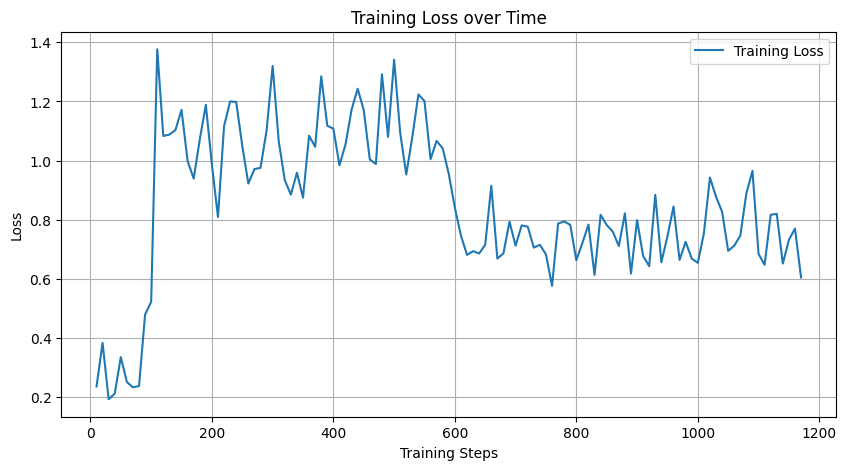

In [ ]:
import matplotlib.pyplot as plt

losses = []
steps = []

for log in trainer.state.log_history:
    if "loss" in log:
        losses.append(log["loss"])
        steps.append(log["step"])

plt.figure(figsize=(10, 5))
plt.plot(steps, losses, label="Training Loss")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training Loss over Time")
plt.grid(True)
plt.legend()
plt.show()


### costum training

In [ ]:
from torch.utils.data import DataLoader
from torch.optim import AdamW
from tqdm import tqdm

def freeze_all_bert_layers(model):
    for param in model.roberta.parameters():
        param.requires_grad = False

    for param in model.qa_outputs.parameters():
        param.requires_grad = True

def unfreeze_last_n_layers(model, n):
    for layer in model.roberta.encoder.layer[-n:]:
        for param in layer.parameters():
            param.requires_grad = True



train_dataloader = DataLoader(tokenized_datasets["train"], batch_size=8, shuffle=True, collate_fn=default_data_collator)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#model.gradient_checkpointing_enable()

freeze_all_bert_layers(model)
unfreeze_last_n_layers(model,6)
'''
for param in model.qa_outputs.parameters():
    param.requires_grad = True
for layer in model.roberta.encoder.layer:
    for param in layer.parameters():
        param.requires_grad = True
'''
model.to(device)

optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=3e-5)
from transformers import get_scheduler

num_epochs = 1
num_training_steps = num_epochs * len(train_dataloader)
num_warmup_steps = int(0.5 * num_training_steps)

lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)



In [ ]:
from torch.utils.data import DataLoader
from torch.optim import AdamW
from tqdm import tqdm


train_dataloader = DataLoader(tokenized_datasets["train"], batch_size=4, shuffle=True, collate_fn=default_data_collator)

#optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Freeze all, then unfreeze QA + N last layers
#freeze_all_bert_layers(model)
#unfreeze_last_n_layers(model,12)


from peft import get_peft_model, LoraConfig, TaskType, PeftModel

# 2. Define LoRA configuration
peft_config = LoraConfig(
    r=32,
    lora_alpha=32,
    target_modules=["query", "value"],  # You can use "q_proj", "v_proj" for other architectures
    lora_dropout=0.2,
    bias="none",
    task_type=TaskType.QUESTION_ANS
)

from peft import PeftModel
if not isinstance(model, PeftModel):
    model = get_peft_model(model, peft_config)

for param in model.parameters():
    param.requires_grad = False

for param in model.qa_outputs.parameters():
    param.requires_grad = True

for name, param in model.named_parameters():
    if "lora_" in name:
        param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("\n=== Sanity check: are base encoder weights frozen? ===")
for i, layer in enumerate(model.roberta.encoder.layer):
    base_trainable = any(
        "lora_" not in name and param.requires_grad
        for name, param in layer.named_parameters()
    )
    status = "🟢 BASE trainable" if base_trainable else "🔴 base frozen"
    print(f"Layer {i:<2}: {status}")
model.print_trainable_parameters()

from torch.optim import AdamW
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

from transformers import get_scheduler

num_epochs = 1
num_training_steps = num_epochs * len(train_dataloader)
num_warmup_steps = int(0.4 * num_training_steps)

lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)




In [ ]:
for param in model.qa_outputs.parameters():
    param.requires_grad = True

for name, param in model.named_parameters():
    if "lora_" in name:
        param.requires_grad = True

from torch.optim import AdamW
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-5)

from transformers import get_scheduler

num_epochs = 1
num_training_steps = num_epochs * len(train_dataloader)
num_warmup_steps = int(0.4 * num_training_steps)

lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

def focal_loss(logits, targets, gamma=2.0, reduction='mean'):
    log_probs = F.log_softmax(logits, dim=-1)
    probs = torch.exp(log_probs)
    target_log_probs = log_probs.gather(dim=-1, index=targets.unsqueeze(-1)).squeeze(-1)
    target_probs = probs.gather(dim=-1, index=targets.unsqueeze(-1)).squeeze(-1)

    loss = -((1 - target_probs) ** gamma) * target_log_probs
    return loss.mean() if reduction == 'mean' else loss

def qa_focal_loss(start_logits, end_logits, start_positions, end_positions, gamma=2.0):
    start_loss = focal_loss(start_logits, start_positions, gamma=gamma)
    end_loss = focal_loss(end_logits, end_positions, gamma=gamma)
    return (start_loss + end_loss) / 2

##########

def make_binary_targets(positions, seq_len):
    # positions: (batch,)
    # returns: (batch, seq_len)
    batch_size = positions.size(0)
    binary = torch.zeros((batch_size, seq_len), device=positions.device)
    binary[torch.arange(batch_size), positions] = 1.0
    return binary

def loss_fn(out1,out2,target1,target2):
  l1 = nn.BCEWithLogitsLoss()(out1, target1.float())
  l2 = nn.BCEWithLogitsLoss()(out2, target2.float())
  return l1 + l2

num_epochs = 1

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    model.train()
    totall_loss = 0

    progress_bar = tqdm(train_dataloader)
    for batch in progress_bar:
        batch = {k: v.to(device) for k, v in batch.items() if k != "offset_mapping"}
        '''
        outputs = model(**batch)
        loss = outputs.loss


        outputs = model(**batch)
        loss = qa_focal_loss(
            outputs.start_logits,
            outputs.end_logits,
            batch["start_positions"],
            batch["end_positions"],
            gamma=1.6
        )
        '''

        outputs = model(**batch)
        start_logits = outputs.start_logits  # shape: (batch, seq_len)
        end_logits = outputs.end_logits

        seq_len = start_logits.size(1)

        # Convert class indices to binary vectors
        target_start = make_binary_targets(batch["start_positions"], seq_len)
        target_end = make_binary_targets(batch["end_positions"], seq_len)

        loss = loss_fn(start_logits, end_logits, target_start, target_end)


        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        totall_loss += loss.item()
        progress_bar.set_description(f"Loss: {loss.item():.4f}")

    avg_loss = totall_loss / len(train_dataloader)
    print(f"Epoch {epoch+1} average loss: {avg_loss:.4f}")


Epoch 1/1


Loss: 0.0039: 100%|██████████| 2221/2221 [26:28<00:00,  1.40it/s]

Epoch 1 average loss: 0.0055


In [ ]:
for i, layer in enumerate(model.roberta.encoder.layer):
    any_trainable = any(p.requires_grad for p in layer.parameters())
    status = "🟢 trainable" if any_trainable else "🔴 frozen"
    print(f"Layer {i:<2}: {status}")


In [ ]:
# Save model
#model.save_pretrained("/content/drive/MyDrive/xlm_full_85")

# Save tokenizer
#tokenizer.save_pretrained("/content/drive/MyDrive/xlm_full_85")

In [ ]:
# Load from saved directory

from transformers import AutoTokenizer, AutoModelForQuestionAnswering
from peft import PeftModel, PeftConfig


lora_model_path = "..." # replace this
peft_config = PeftConfig.from_pretrained(lora_model_path)
base_model = AutoModelForQuestionAnswering.from_pretrained(peft_config.base_model_name_or_path)
model = PeftModel.from_pretrained(base_model, lora_model_path)
tokenizer = AutoTokenizer.from_pretrained(peft_config.base_model_name_or_path)



In [ ]:
import torch

torch.cuda.empty_cache()        # Frees unused memory back to CUDA
torch.cuda.ipc_collect()        # Cleans up memory shared between processes


### test

In [ ]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

repo_id = "mmatinm/mpersian_xlm_roberta_large"

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(repo_id)
model = AutoModelForQuestionAnswering.from_pretrained(repo_id)



tokenizer_config.json: 0.00B [00:00, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/965 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Answer: <s>


In [ ]:
def clean_text(text):
    import re

    # Normalize Persian/Arabic characters
    text = text.replace('ك', 'ک').replace('ي', 'ی').replace('ۀ', 'ه').replace('ة', 'ه')
    text = text.replace('أ', 'ا').replace('إ', 'ا').replace('ؤ', 'و').replace('ئ', 'ی').replace('آ', 'ا')
    # Remove ZWNJ and Tatweel
    text = text.replace('\u200c', '')  # ZWNJ
    text = text.replace('\u0640', '')  # Tatweel (kashida)
    text = text.replace('\u200d', '')  # ZWJ
    text = text.replace('\u200e', '')  # ZWJ
    text = text.replace('\u200f', '')  # ZWJ
    # Remove extra space around math and assignment symbols
    text = re.sub(r'\s*=\s*', '=', text)
    text = re.sub(r'\s*\+\s*', '+', text)
    text = re.sub(r'\s*-\s*', '-', text)
    text = re.sub(r'\s*\*\s*', '*', text)
    text = re.sub(r'\s*/\s*', '/', text)
    # Remove spaces around long dash
    text = re.sub(r'\s*–\s*', '–', text)
    # Normalize ellipsis variations (e.g. "و…", "و …" → "و...")
    text = re.sub(r'\s*…', '...', text)
    text = text.replace('...', '…')  # unify all to Persian ellipsis
    # Normalize spacing around hyphens
    text = re.sub(r'\s*-\s*', '-', text)
    # Collapse multiple spaces
    text = re.sub(r'\s+', ' ', text)
    # Remove space before Persian/English punctuation
    text = re.sub(r'\s+([.,،؛!?])', r'\1', text)
    # Add space after punctuation if missing
    text = re.sub(r'([.,،؛!?])([^\s])', r'\1 \2', text)
    # Lowercase English
    text = re.sub(r'[A-Z]', lambda m: m.group(0).lower(), text)

    return text.strip()


def load_pqa(path):
    import json

    with open(path, encoding='utf-8') as f:
        data = json.load(f)

    samples = []
    for article in data["data"]:
        for paragraph in article["paragraphs"]:
            original_context = paragraph["context"]
            context = clean_text(original_context)

            for qa in paragraph["qas"]:
                question = clean_text(qa["question"])
                id_ = qa["id"]
                is_impossible = qa.get("is_impossible", False)
                answers = qa["answers"]

                answer_texts = []
                answer_starts = []
                answer_ends = []

                for ans in answers:
                    answer_text_raw = ans["text"]
                    answer_text = clean_text(answer_text_raw)

                    start = context.find(answer_text)
                    if start != -1:
                        answer_texts.append(answer_text)
                        answer_starts.append(start)
                        answer_ends.append(start + len(answer_text))
                    else:
                        # Log or skip misaligned answers if needed
                        #print(f"⚠️ Could not find answer in context for id {id_}")
                        continue

                samples.append({
                    "id": str(id_),
                    "context": context,
                    "question": question,
                    "is_impossible": is_impossible,
                    "answers": {
                        "text": answer_texts,
                        "answer_start": answer_starts,
                        "answer_end": answer_ends
                    }
                })
    return samples

In [ ]:

import evaluate

device = 0 if torch.cuda.is_available() else -1
model.to(device)

test_samples = load_pqa("/content/drive/MyDrive/PersianQA/pqa_test.json")
test_dataset = Dataset.from_list(test_samples)

def preprocess_test(example):
    questions = [q.strip() for q in example["question"]]
    contexts = example["context"]

    tokenized = tokenizer(
        questions,
        contexts,
        max_length=512,
        stride=128,
        truncation="only_second",
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        return_token_type_ids=True,
        padding="max_length"
    )

    tokenized["example_id"] = []
    sample_mapping = tokenized.pop("overflow_to_sample_mapping")
    offset_mapping = tokenized["offset_mapping"]

    for i in range(len(tokenized["input_ids"])):
        sequence_ids = tokenized.sequence_ids(i)
        tokenized["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None
            for k, o in enumerate(offset_mapping[i])
        ]
        tokenized["example_id"].append(example["id"][sample_mapping[i]])

    return tokenized

tokenized_test = test_dataset.map(preprocess_test, batched=True, remove_columns=test_dataset.column_names)

from torch.utils.data import DataLoader

def qa_collate_fn(features):
    keys_to_keep = ['input_ids', 'attention_mask']#, 'token_type_ids']
    batch = {k: torch.tensor([f[k] for f in features]) for k in keys_to_keep if k in features[0]}
    return batch

def postprocess_qa_predictions(tokenized_dataset, raw_dataset, model, tokenizer, n_best_size=20, max_answer_length=30, null_score_diff_threshold=0.0):
    model.eval()
    dataloader = DataLoader(tokenized_dataset, batch_size=8, collate_fn=qa_collate_fn)

    all_start_logits = []
    all_end_logits = []

    for batch in tqdm(dataloader, desc="Running inference"):
        with torch.no_grad():
            inputs = {k: v.to(model.device) for k, v in batch.items()}
            outputs = model(**inputs)
            all_start_logits.append(outputs.start_logits.cpu().numpy())
            all_end_logits.append(outputs.end_logits.cpu().numpy())

    start_logits = np.concatenate(all_start_logits, axis=0)
    end_logits = np.concatenate(all_end_logits, axis=0)

    predictions = []

    for i, example in enumerate(raw_dataset):
        offsets = tokenized_dataset[i]['offset_mapping']
        input_ids = tokenized_dataset[i]['input_ids']

        start_logit = start_logits[i]
        end_logit = end_logits[i]

        cls_index = input_ids.index(tokenizer.cls_token_id)
        cls_score = start_logit[cls_index] + end_logit[cls_index]

        max_score = -float('inf')
        answer = ""

        for start_index in range(len(start_logit)):
            for end_index in range(start_index, min(start_index + max_answer_length, len(end_logit))):
                if offsets[start_index] is None or offsets[end_index] is None:
                    continue
                score = start_logit[start_index] + end_logit[end_index]
                if score > max_score:
                    max_score = score
                    start_char = offsets[start_index][0]
                    end_char = offsets[end_index][1]
                    answer = example["context"][start_char:end_char]


        if cls_score > max_score + null_score_diff_threshold:
            predictions.append({
                "id": str(example["id"]),
                "prediction_text": "",
                "no_answer_probability": 1.0
            })
        else:
            cleaned_answer = clean_text(example["context"][start_char:end_char])
            predictions.append({
                "id": str(example["id"]),
                "prediction_text": cleaned_answer,
                "no_answer_probability": 0.0
            })

    return predictions

predictions = postprocess_qa_predictions(
    tokenized_test,
    test_dataset,
    model,
    tokenizer,
    null_score_diff_threshold=0.0
)


references = [{
    'id': str(item['id']),
    'answers': {
        'text': [clean_text(t) for t in item['answers']['text']],
        'answer_start': item['answers']['answer_start']
    }
} for item in test_samples]


# Step 7: Evaluate using squad_v2
metric = evaluate.load("squad_v2")
results = metric.compute(predictions=predictions, references=references)

# Step 8: Print scores
print("F1 Score:", results['f1'])
print("Exact Match:", results['exact'])

Map:   0%|          | 0/930 [00:00<?, ? examples/s]

Running inference: 100%|██████████| 117/117 [01:21<00:00,  1.43it/s]


F1 Score: 85.3197419641517
Exact Match: 71.61290322580645


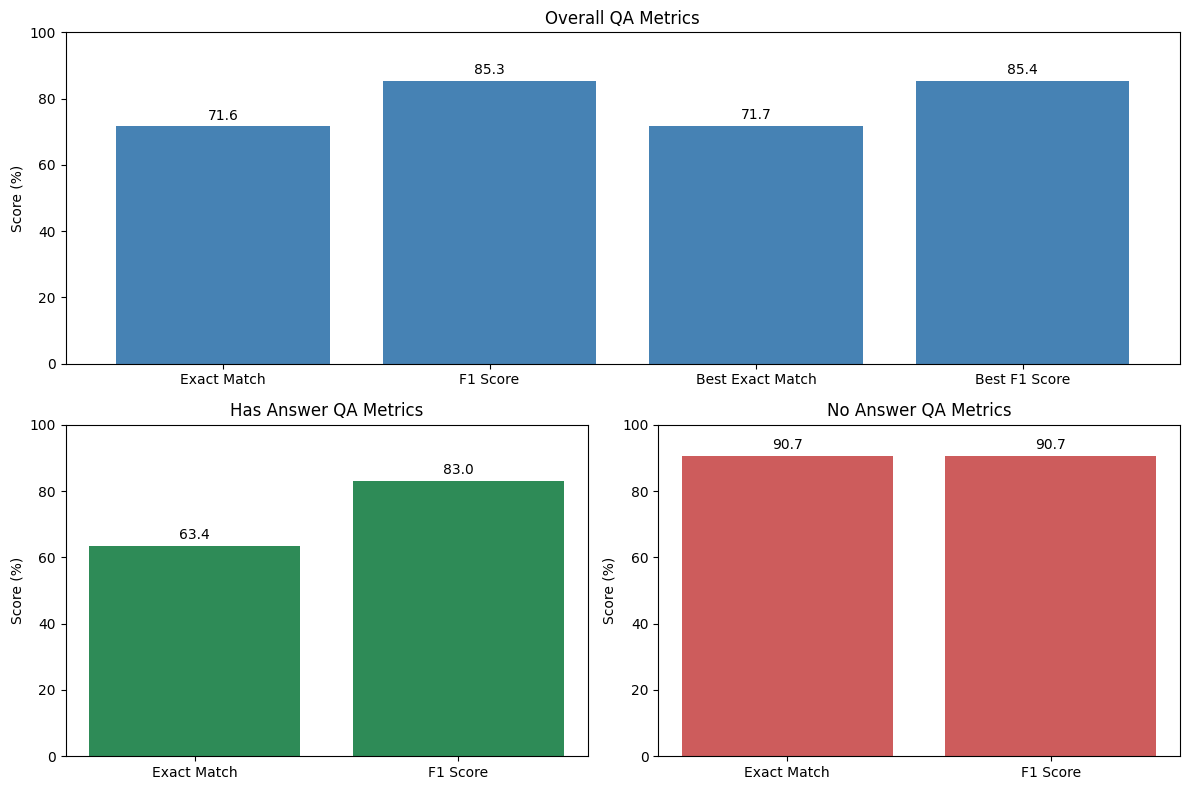

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 8))

gs = fig.add_gridspec(2, 2, height_ratios=[1, 1])

ax1 = fig.add_subplot(gs[0, :])
overall_labels = ['Exact Match', 'F1 Score', 'Best Exact Match', 'Best F1 Score']
overall_scores = [results['exact'], results['f1'], results['best_exact'], results['best_f1']]
ax1.bar(overall_labels, overall_scores, color='steelblue')
ax1.set_ylim(0, 100)
ax1.set_title('Overall QA Metrics')
ax1.set_ylabel('Score (%)')
for i, v in enumerate(overall_scores):
    ax1.text(i, v + 2, f"{v:.1f}", ha='center')

ax2 = fig.add_subplot(gs[1, 0])
hasans_labels = ['Exact Match', 'F1 Score']
hasans_scores = [results['HasAns_exact'], results['HasAns_f1']]
ax2.bar(hasans_labels, hasans_scores, color='seagreen')
ax2.set_ylim(0, 100)
ax2.set_title('Has Answer QA Metrics')
ax2.set_ylabel('Score (%)')
for i, v in enumerate(hasans_scores):
    ax2.text(i, v + 2, f"{v:.1f}", ha='center')

ax3 = fig.add_subplot(gs[1, 1])
noans_labels = ['Exact Match', 'F1 Score']
noans_scores = [results['NoAns_exact'], results['NoAns_f1']]
ax3.bar(noans_labels, noans_scores, color='indianred')
ax3.set_ylim(0, 100)
ax3.set_title('No Answer QA Metrics')
ax3.set_ylabel('Score (%)')
for i, v in enumerate(noans_scores):
    ax3.text(i, v + 2, f"{v:.1f}", ha='center')

plt.tight_layout()
plt.show()


In [ ]:
import evaluate
import random
import torch
import numpy as np

metric = evaluate.load("squad_v2")

sample = random.choice(test_samples)  # From load_pqa()

context = clean_text(sample["context"])
question = clean_text(sample["question"])

tokenized = tokenizer(
    question,
    context,
    return_offsets_mapping=True,
    truncation="only_second",
    max_length=384,
    stride=64,
    padding="max_length",
    return_token_type_ids=True
)

input_ids = tokenized["input_ids"]
offset_mapping = tokenized["offset_mapping"]
sequence_ids = tokenized.sequence_ids()

input_ids_tensor = torch.tensor([input_ids]).to(model.device)
attention_mask_tensor = torch.tensor([tokenized["attention_mask"]]).to(model.device)

with torch.no_grad():
    outputs = model(
        input_ids=input_ids_tensor,
        attention_mask=attention_mask_tensor
    )
    start_logits = outputs.start_logits[0].cpu().numpy()
    end_logits = outputs.end_logits[0].cpu().numpy()


cls_index = input_ids.index(tokenizer.cls_token_id)
cls_score = start_logits[cls_index] + end_logits[cls_index]

max_score = -float("inf")
best_answer = ""
max_answer_length = 30

for start_index in range(len(start_logits)):
    for end_index in range(start_index, min(start_index + max_answer_length, len(end_logits))):
        if offset_mapping[start_index] is None or offset_mapping[end_index] is None:
            continue
        if sequence_ids[start_index] != 1 or sequence_ids[end_index] != 1:
            continue
        score = start_logits[start_index] + end_logits[end_index]
        if score > max_score:
            max_score = score
            start_char = offset_mapping[start_index][0]
            end_char = offset_mapping[end_index][1]
            best_answer = context[start_char:end_char]

if cls_score > max_score:
    predicted_text = ""
    no_answer = True
else:
    predicted_text = clean_text(best_answer)
    no_answer = False


prediction = [{
    "id": str(sample["id"]),
    "prediction_text": predicted_text,
    "no_answer_probability": 1.0 if no_answer else 0.0
}]

reference = [{
    "id": str(sample["id"]),
    "answers": {
        "text": [clean_text(t) for t in sample["answers"]["text"]],
        "answer_start": sample["answers"]["answer_start"]
    }
}]

# Compute metrics
results = metric.compute(predictions=prediction, references=reference)

# Output
print("\n--- RANDOM SAMPLE ---")
print(f"📌 Question: {question}")
print(f"📚 Context: {context}")
print(f"✅ Ground Truth Answer(s): {reference[0]['answers']['text']}")
print(f"🤖 Model Prediction: {predicted_text if predicted_text else 'no answer'}")
print(f"📈 SQuAD EM: {results['exact']}")
print(f"📉 SQuAD F1: {results['f1']:.2f}")



--- RANDOM SAMPLE ---
📌 Question: ابراهام لینکلن کجا بزرگ شد؟
📚 Context: ابراهام لینکُلْن (۱۲ فوریهٔ ۱۸۰۹–۱۵ اوریل ۱۸۶۵) یک دولتمرد و وکیل امریکایی بود که از سال ۱۸۶۱ تا زمان ترور وی در سال ۱۸۶۵ به عنوان شانزدهمین رییسجمهور ایالات متحدهٔ امریکا خدمت می کرد. لینکلن کشور را در زمان جنگ داخلی امریکا، بزرگترین بحران اخلاقی و سیاسی کشور، رهبری کرد. در دوران ریاستجمهوریاش وی موفق به حفظ اتحادیه، الغای برده داری، تقویت دولت فدرال و مدرنسازی اقتصاد ایالات متحده شد. لینکلن در خانوادهای تهیدست در یک کلبه چوبی واقع در ایالت کنتاکی متولد شد و در در ایالت ایندیانا بزرگ شد. او خود تحصیل کرده بود و به یک وکیل، رهبر حزب ویگ و نماینده مجلس نمایندگان ایالات متحده امریکا از ایالت ایلینوی تبدیل شد. در سال ۱۸۴۹، او سیاست را ترک کرد و به وکالت پرداخت، اما پس از حدود ۵ سال در سال ۱۸۵۴ دوباره به دنیای سیاست بازگشت و به عنوان رهبر حزب تازه تاسیس جمهوریخواه شناخته شد. لینکلن در سال ۱۸۶۰ کاندیدای ریاست جمهوری شد و با پیروزی در تمامی ایالات شمالی به عنوان اولین رییسجمهور از حزب جمهوریخواه برگزیده شد.
✅ Ground Tr